## Simulation - Sophie Ensing

In [1]:
# Package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# You need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# Spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# Package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.model as model

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

### Import data

In [2]:
# Import stations and lines from excel sheets
df1 = pd.read_csv("../../stations.csv")
df2 = pd.read_csv("../../lijnen.csv")

# Convert columns to lst type
from ast import literal_eval
df2.loc[:,'Route1'] = df2.loc[:,'Route1'].apply(lambda x: literal_eval(x))
df2.loc[:,'Route2'] = df2.loc[:,'Route2'].apply(lambda x: literal_eval(x))
df2.loc[:,'Duration'] = df2.loc[:,'Duration'].apply(lambda x: literal_eval(x))

In [3]:
# Create dictionary for all transport lines
lines = {}
durations = []

for index, row in df2.iterrows():
    lines[row["Line"]] = (row["Route1"], row["Route2"], row["Duration"])
    
edges = []
for k, v in lines.items():
    for x in range(len(v[0])):
        try:
            edges.append((v[0][x], v[0][x + 1], k, v[2][x]))
            edges.append((v[0][x + 1], v[0][x], k, v[2][x]))
        except:
            break

### Create graph

In [4]:
# Create graph
FG = nx.DiGraph()

# Create all stations and nodes
Node = type('Station', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.Station), {})
nodes = []
stations = []

for index, row in df1.iterrows():
    stations.append({"env": [],
                     "name": row["HalteNaam"],
                     "geometry": shapely.geometry.Point(row["HalteLat"], row["HalteLon"]),
                     "capacity": row["Capacity"]}) 

for station in stations:
    node = Node(**station)
    nodes.append(node)

# Create positions and add nodes to graph with right position
positions = {}

for node in nodes:
    positions[node.name] = (node.geometry.y, node.geometry.x)
    FG.add_node(node.name, geometry = node.geometry, object_type = node)

# Create all edges
for edge in edges:
    FG.add_edge(edge[0], edge[1], line = edge[2], duration = edge[3])

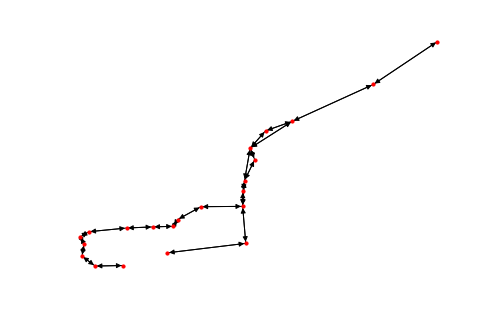

In [5]:
# Plot the network
nx.draw(FG, positions, node_size=10)
plt.show()

In [6]:
FG.nodes

NodeView(('Noord', 'Noorderpark', 'CentraalStation', 'Rokin', 'Vijzelgracht', 'DePijp', 'Europaplein', 'Zuid', 'Dam', 'Muntplein', 'MarieHeinekenplein', 'RoelofHartplein', 'GerritvdVeenstraat', 'Beethovenstraat', 'Minervaplein', 'Olympiaplein', 'Olympiaweg', 'OlympischStadion', 'IJsbaanpad', 'Amstelveenseweg', 'VUMedischCentrum', 'DeBoelelaanVU'))

In [7]:
# Calculate transfers and durations
def route_calculation(route, graph):
    route_info = {"lines": [], "duration": 0, "transfers": 0, "transferstations": []}
    
    for i in range(len(route) - 1):
        if route_info["lines"] != []:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            if line != attr['line']:
                route_info["transfers"] += 1
                route_info["transferstations"].append(route[i])
            line = attr['line']
            route_info["lines"].append(line) 
        else:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            line = attr['line']
            route_info["lines"].append(line) 

        route_info["duration"] += attr['duration']

    route_info["lines"] = set(route_info["lines"])
    return route_info

route_calculation(['Olympiaweg','Olympiaplein','Minervaplein','Beethovenstraat','GerritvdVeenstraat',
  'RoelofHartplein','DePijp','Vijzelgracht','Rokin','CentraalStation','Noorderpark','Noord'], FG)

{'lines': {'metro52', 'tram24'},
 'duration': 21,
 'transfers': 1,
 'transferstations': ['DePijp']}

### Create moving parts

In [8]:
def generate_passenger(origin, destination, environment):
    """ Generate a passenger """
    Passenger = type('Passenger', (core.Identifiable, core.Routeable, core.Log), {})
    
    # Name of the object
    name = "Passenger"
    
    # Geometry of the origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
    
    # Travel direction
    route = nx.dijkstra_path(environment.FG, origin, destination, weight = 'duration')
    
    transfers = 1
    
    return Passenger(**{"env": environment, 
                        "name": name, 
                        "route": route,
                        "transfers": transfers,
                        })

In [9]:
def generate_metro(line, environment):
    """ Generate a metro """
    Metro = type('Metro', (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, 
                           core.Routeable, core.Mover), {})

    # Name of the object
    name = "Metro"

    # Travel direction
    route = line    

    # Geometry of origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[route[0]].geometry
    
    # Maximum passengers
    capacity = 50
    
    return Metro(**{"env": environment, 
                    "name": name, 
                    "route": route, 
                    "capacity": capacity, 
                    "geometry": geometry})

### Spawn the metro trains

In [10]:
def vehicle(env, start, frequency, line):
    yield env.timeout(start * 60 * 60)
    while True:
        metro = generate_metro(line, env)
        env.metros.append(metro)
        env.process(metro.move())
        
        # One metro every X minutes
        yield env.timeout(frequency * 60)

In [11]:
def passengers(env):
    yield env.timeout(5.5 * 60 * 60)
    while True:
        origin, destination = random.sample(env.FG.nodes, 2)

        passenger = generate_passenger(origin, destination, env)
        FG.nodes[origin]["object_type"].units.append(passenger)

        passenger.log_entry("Waiting for metro start", env.now, 0, nx.get_node_attributes(env.FG, "object_type")[origin].geometry)
        
        env.passengers.append(passenger)

        # Random arrivals of passengers with mean interarrival time of 30 seconds
        yield env.timeout(random.random() * 60)

### Run simulation

In [12]:
# Simulation start time
simulation_start = datetime.datetime(2019, 1, 1)

# Make simulation environment
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.FG = FG

# For loggin
env.metros = []
env.passengers = []

# Start the simulation
env.process(vehicle(env, 5.5, 6, lines["metro52"][0]))
env.process(vehicle(env, 5.585, 6, lines["metro52"][1]))
env.process(vehicle(env, 6, 10, lines["tram24"][0]))
env.process(vehicle(env, 6, 10, lines["tram24"][1]))
env.process(passengers(env))
env.run(until = env.now + 1 * 7 * 60 * 60)

### Check results

In [11]:
# env.metros[17].log['Timestamp'][0].strftime ('%H:%M:%S')
env.metros[16].log

{'Message': ['Loading start',
  'Loading stop',
  'Driving from DeBoelelaanVU to VUMedischCentrum start',
  'Passengers: 1',
  'Driving from DeBoelelaanVU to VUMedischCentrum stop',
  'Unloading start',
  'Unloading stop',
  'Loading start',
  'Loading stop',
  'Driving from VUMedischCentrum to Amstelveenseweg start',
  'Passengers: 2',
  'Driving from VUMedischCentrum to Amstelveenseweg stop',
  'Unloading start',
  'Unloading stop',
  'Driving from Amstelveenseweg to IJsbaanpad start',
  'Passengers: 2',
  'Driving from Amstelveenseweg to IJsbaanpad stop',
  'Unloading start',
  'Unloading stop',
  'Driving from IJsbaanpad to OlympischStadion start',
  'Passengers: 2',
  'Driving from IJsbaanpad to OlympischStadion stop',
  'Unloading start',
  'Unloading stop',
  'Loading start',
  'Loading stop',
  'Driving from OlympischStadion to Olympiaweg start',
  'Passengers: 3',
  'Driving from OlympischStadion to Olympiaweg stop',
  'Unloading start',
  'Unloading stop',
  'Driving from Oly

In [15]:
env.passengers[2].__dict__

{'env': <simpy.core.Environment at 0xa19763160>,
 'log': {'Message': ['Waiting for metro start',
   'Waiting for metro stop',
   'In metro start',
   'I HAVE A TRANSFER',
   'I HAVE A TRANSFER',
   'I HAVE A TRANSFER',
   'I HAVE A TRANSFER',
   'I HAVE A TRANSFER',
   'I HAVE A TRANSFER',
   'I HAVE A TRANSFER',
   'I HAVE A TRANSFER',
   'I HAVE A TRANSFER',
   'I HAVE A TRANSFER',
   'I HAVE A TRANSFER',
   'I HAVE A TRANSFER'],
  'Timestamp': [datetime.datetime(2019, 1, 1, 5, 31, 47, 8280),
   datetime.datetime(2019, 1, 1, 6, 8, 15),
   datetime.datetime(2019, 1, 1, 6, 8, 15),
   datetime.datetime(2019, 1, 1, 6, 10, 15),
   datetime.datetime(2019, 1, 1, 6, 12, 30),
   datetime.datetime(2019, 1, 1, 6, 13, 45),
   datetime.datetime(2019, 1, 1, 6, 15),
   datetime.datetime(2019, 1, 1, 6, 17, 15),
   datetime.datetime(2019, 1, 1, 6, 20, 30),
   datetime.datetime(2019, 1, 1, 6, 22, 45),
   datetime.datetime(2019, 1, 1, 6, 24),
   datetime.datetime(2019, 1, 1, 6, 27, 15),
   datetime.dat

In [16]:
passengerdf = pd.DataFrame.from_dict(env.passengers[50].log)
passengerdf

,Message,Timestamp,Value,Geometry
0,Waiting for metro start,2019-01-01 05:56:18.056001,0,POINT (52.34528169 4.8587373)


In [17]:
passengerdict = {}

for i in range(len(env.passengers)):
    try:
        passengerdict[env.passengers[i].id] = {"route": env.passengers[i].route, 
                                        "origin": env.passengers[i].route[0], 
                                        "destination": env.passengers[i].route[-1], 
                                        "transfers": 0, 
                                        "waiting_time": 0, 
                                        "modes": 0, 
                                        "transferindex": 0, 
                                        "creation": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "departure": env.passengers[i].log["Timestamp"][2].strftime ('%H:%M:%S'),
                                        "arrival": env.passengers[i].log["Timestamp"][3].strftime ('%H:%M:%S'), 
                                        "class": 0, 
                                        "date": env.passengers[i].log["Timestamp"][0].date()}
    except:
        pass
    
passengerdf = pd.DataFrame(passengerdict).T
passengerdf.to_csv("../../passengers.csv", index=True)

In [18]:
env.metros[5].__dict__

{'units': [],
 'env': <simpy.core.Environment at 0x11cd69320>,
 'log': {'Message': ['Driving from Zuid to Europaplein start',
   'Driving from Zuid to Europaplein stop',
   'Unloading start',
   'Unloading stop',
   'Driving from Europaplein to DePijp start',
   'Driving from Europaplein to DePijp stop',
   'Unloading start',
   'Unloading stop',
   'Driving from DePijp to Vijzelgracht start',
   'Driving from DePijp to Vijzelgracht stop',
   'Unloading start',
   'Unloading stop',
   'Loading start',
   'Loading stop',
   'Driving from Vijzelgracht to Rokin start',
   'Driving from Vijzelgracht to Rokin stop',
   'Unloading start',
   'Unloading stop',
   'Driving from Rokin to CentraalStation start',
   'Driving from Rokin to CentraalStation stop',
   'Unloading start',
   'Unloading stop',
   'Driving from CentraalStation to Noorderpark start',
   'Driving from CentraalStation to Noorderpark stop',
   'Unloading start',
   'Unloading stop',
   'Driving from Noorderpark to Noord star

In [19]:
vehicledict = {}

for i in range(len(env.metros)):
    try:
        vehicledict[env.metros[i].id] = {"route": env.metros[i].route, 
                                        "mode": env.metros[i].name, 
                                        "departure": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "arrival": env.passengers[i].log["Timestamp"][-1].strftime ('%H:%M:%S'), 
                                        "date": env.passengers[i].log["Timestamp"][0].date()}
    except:
        pass
    
vehicledf = pd.DataFrame(vehicledict).T
vehicledf.to_csv("../../vehicles.csv", index=True)

In [20]:
vehicledf

,arrival,date,departure,mode,route
2eb8d07a-6fd0-11e9-8461-7831c1d08f6a,06:34:00,2019-01-01,05:30:00,Metro,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
2eba1c52-6fd0-11e9-b353-7831c1d08f6a,05:30:52,2019-01-01,05:30:52,Metro,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
2eba57da-6fd0-11e9-adef-7831c1d08f6a,06:24:00,2019-01-01,05:30:53,Metro,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
2ebddbba-6fd0-11e9-9479-7831c1d08f6a,05:31:32,2019-01-01,05:31:32,Metro,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
2ebe4b06-6fd0-11e9-a041-7831c1d08f6a,06:28:30,2019-01-01,05:32:14,Metro,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
2ebfa0d2-6fd0-11e9-b403-7831c1d08f6a,06:31:45,2019-01-01,05:33:04,Metro,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
2ec029b4-6fd0-11e9-9c6f-7831c1d08f6a,06:29:30,2019-01-01,05:33:07,Metro,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
2ec197de-6fd0-11e9-b2d1-7831c1d08f6a,06:31:15,2019-01-01,05:33:55,Metro,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
2ec1ec48-6fd0-11e9-bb21-7831c1d08f6a,05:34:08,2019-01-01,05:34:08,Metro,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
2ec53d76-6fd0-11e9-9566-7831c1d08f6a,06:21:15,2019-01-01,05:34:24,Metro,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."


In [21]:
passengerdf

,arrival,class,creation,date,departure,destination,modes,origin,route,transferindex,transfers,waiting_time
2eb986de-6fd0-11e9-9884-7831c1d08f6a,06:34:00,0,05:30:00,2019-01-01,06:20:15,DeBoelelaanVU,0,Beethovenstraat,"[Beethovenstraat, Minervaplein, Olympiaplein, ...",0,0,0
2eb99d40-6fd0-11e9-a17c-7831c1d08f6a,06:24:00,0,05:30:53,2019-01-01,06:00:00,Vijzelgracht,0,DeBoelelaanVU,"[DeBoelelaanVU, VUMedischCentrum, Amstelveense...",0,0,0
2eb9b386-6fd0-11e9-8eef-7831c1d08f6a,06:28:30,0,05:32:14,2019-01-01,06:14:00,Rokin,0,Beethovenstraat,"[Beethovenstraat, GerritvdVeenstraat, RoelofHa...",0,0,0
2eb9cff4-6fd0-11e9-a69c-7831c1d08f6a,06:31:45,0,05:33:04,2019-01-01,06:26:00,VUMedischCentrum,0,Olympiaweg,"[Olympiaweg, OlympischStadion, IJsbaanpad, Ams...",0,0,0
2eb9d81e-6fd0-11e9-9ce3-7831c1d08f6a,06:29:30,0,05:33:07,2019-01-01,06:21:30,Amstelveenseweg,0,Minervaplein,"[Minervaplein, Olympiaplein, Olympiaweg, Olymp...",0,0,0
2eb9de86-6fd0-11e9-85d4-7831c1d08f6a,06:31:15,0,05:33:55,2019-01-01,06:30:15,Minervaplein,0,Beethovenstraat,"[Beethovenstraat, Minervaplein]",0,0,0
2eb9efd4-6fd0-11e9-9de9-7831c1d08f6a,06:21:15,0,05:34:24,2019-01-01,06:00:00,Minervaplein,0,CentraalStation,"[CentraalStation, Rokin, Vijzelgracht, DePijp,...",0,0,0
2eba1228-6fd0-11e9-8485-7831c1d08f6a,06:10:15,0,05:34:47,2019-01-01,06:04:30,Olympiaplein,0,Amstelveenseweg,"[Amstelveenseweg, IJsbaanpad, OlympischStadion...",0,0,0
2eba4664-6fd0-11e9-bb89-7831c1d08f6a,06:44:00,0,05:35:29,2019-01-01,06:31:30,DeBoelelaanVU,0,Minervaplein,"[Minervaplein, Olympiaplein, Olympiaweg, Olymp...",0,0,0
2eba4e0c-6fd0-11e9-9d83-7831c1d08f6a,05:49:21,0,05:35:39,2019-01-01,05:40:36,Noorderpark,0,DePijp,"[DePijp, Vijzelgracht, Rokin, CentraalStation,...",0,0,0


In [22]:
stationdf = passengerdf
stationdf["OD"] = stationdf["origin"] + "," + stationdf["destination"]
stationdf

,arrival,class,creation,date,departure,destination,modes,origin,route,transferindex,transfers,waiting_time,OD
2eb986de-6fd0-11e9-9884-7831c1d08f6a,06:34:00,0,05:30:00,2019-01-01,06:20:15,DeBoelelaanVU,0,Beethovenstraat,"[Beethovenstraat, Minervaplein, Olympiaplein, ...",0,0,0,"Beethovenstraat,DeBoelelaanVU"
2eb99d40-6fd0-11e9-a17c-7831c1d08f6a,06:24:00,0,05:30:53,2019-01-01,06:00:00,Vijzelgracht,0,DeBoelelaanVU,"[DeBoelelaanVU, VUMedischCentrum, Amstelveense...",0,0,0,"DeBoelelaanVU,Vijzelgracht"
2eb9b386-6fd0-11e9-8eef-7831c1d08f6a,06:28:30,0,05:32:14,2019-01-01,06:14:00,Rokin,0,Beethovenstraat,"[Beethovenstraat, GerritvdVeenstraat, RoelofHa...",0,0,0,"Beethovenstraat,Rokin"
2eb9cff4-6fd0-11e9-a69c-7831c1d08f6a,06:31:45,0,05:33:04,2019-01-01,06:26:00,VUMedischCentrum,0,Olympiaweg,"[Olympiaweg, OlympischStadion, IJsbaanpad, Ams...",0,0,0,"Olympiaweg,VUMedischCentrum"
2eb9d81e-6fd0-11e9-9ce3-7831c1d08f6a,06:29:30,0,05:33:07,2019-01-01,06:21:30,Amstelveenseweg,0,Minervaplein,"[Minervaplein, Olympiaplein, Olympiaweg, Olymp...",0,0,0,"Minervaplein,Amstelveenseweg"
2eb9de86-6fd0-11e9-85d4-7831c1d08f6a,06:31:15,0,05:33:55,2019-01-01,06:30:15,Minervaplein,0,Beethovenstraat,"[Beethovenstraat, Minervaplein]",0,0,0,"Beethovenstraat,Minervaplein"
2eb9efd4-6fd0-11e9-9de9-7831c1d08f6a,06:21:15,0,05:34:24,2019-01-01,06:00:00,Minervaplein,0,CentraalStation,"[CentraalStation, Rokin, Vijzelgracht, DePijp,...",0,0,0,"CentraalStation,Minervaplein"
2eba1228-6fd0-11e9-8485-7831c1d08f6a,06:10:15,0,05:34:47,2019-01-01,06:04:30,Olympiaplein,0,Amstelveenseweg,"[Amstelveenseweg, IJsbaanpad, OlympischStadion...",0,0,0,"Amstelveenseweg,Olympiaplein"
2eba4664-6fd0-11e9-bb89-7831c1d08f6a,06:44:00,0,05:35:29,2019-01-01,06:31:30,DeBoelelaanVU,0,Minervaplein,"[Minervaplein, Olympiaplein, Olympiaweg, Olymp...",0,0,0,"Minervaplein,DeBoelelaanVU"
2eba4e0c-6fd0-11e9-9d83-7831c1d08f6a,05:49:21,0,05:35:39,2019-01-01,05:40:36,Noorderpark,0,DePijp,"[DePijp, Vijzelgracht, Rokin, CentraalStation,...",0,0,0,"DePijp,Noorderpark"
